# 0.0 IMPORTS


In [1]:
import math
import datetime
import inflection
import random
import warnings
warnings.filterwarnings('ignore')
import pickle

import numpy               as np
import pandas              as pd
import xgboost             as xgb
import matplotlib.pyplot   as plt
import seaborn             as sns
import matplotlib.gridspec as gridspec

from scipy                 import stats     as ss
from boruta                import BorutaPy
from IPython.display       import Image
from IPython.core.display  import HTML

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [4]:
def cramer_v(x,y):
    
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    
    
    chi2corr = max(0 ,chi2 - (k-1)* (r-1)/(n-1))
    kcorr = k - (k-1)** 2 /(n-1)
    rcorr = r - (r-1)** 2 /(n-1)
    
    
    return np.sqrt ( ( chi2corr/n)/(min( kcorr-1,rcorr-1))) 

In [5]:
def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )


def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs(( y - yhat ) / y ))

def ml_error (model_name , y , yhat):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ))
             
    
    return pd.DataFrame({ 'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                          'RMSE': rmse}, index = [0])


#def mean_absolute_percentage_error( y, yhat ):
#    return np.mean( np.abs(( y - yhat ) / y ))


In [6]:
def cross_validation (x_training , kfold, model_name, model, verbose=False ) :

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in  range (1, kfold+1):
        if verbose:
            print('\nKFold Number: {}'.format (k))
        #Start and end date for validation

        validation_start_date= x_training['date'] .max() -datetime.timedelta( days = k*6*7)
        validation_end_date= x_training['date'] .max() -datetime.timedelta( days = (k-1)*6*7)

        #Filtering dataset
        training = x_training [x_training['date'] < validation_start_date]
        validation = x_training [( x_training ['date'] >= validation_start_date) & (x_training[ 'date']<= validation_end_date)]


        # Training and  validation dataset
        # Training
        xtraining = training.drop ([ 'date', 'sales'], axis = 1)
        ytraining = training ['sales']


        # Validation
        xvalidation = validation.drop([ 'date','sales'], axis  = 1)
        yvalidation = validation['sales']


        # Model
        m = model.fit ( xtraining, ytraining)

        # Prediction
        yhat =  m.predict( xvalidation )


        # Performace
        m_result = ml_error ( model_name , np.expm1(yvalidation),np.expm1(yhat))

        # Store  Performance of each  kfold iteration
        mae_list.append( m_result ['MAE'] )
        mape_list.append ( m_result ['MAPE'] )
        rmse_list.append( m_result ['RMSE'] )

    return pd.DataFrame({'Model name': model_name,
                         'MAE CV': np.round( np.mean ( mae_list),2).astype( str )+' +/- ' + np.round( np.std( mae_list),2).astype(str),
                         'MAPE CV': np.round( np.mean ( mape_list),2).astype( str )+' +/- ' + np.round( np.std( mape_list),2).astype(str),
                         'RMSE CV': np.round( np.mean ( rmse_list),2).astype( str )+' +/- ' + np.round( np.std( rmse_list),2).astype(str)}, index = [0])

### 0.2 Loading Data

In [7]:
df_sales_raw= pd.read_csv('Data/train.csv',low_memory=False)
df_store_raw= pd.read_csv('Data/store.csv',low_memory=False)

#merge
df_raw  = pd.merge(df_sales_raw,df_store_raw,how='left',on='Store')

# 1.0 DESCRIÇÃO DOS DADOS

In [8]:
df1 = df_raw.copy()

In [9]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1. Rename Columns

In [10]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase= lambda x : inflection .underscore(x)

cols_new= list(map( snakecase, cols_old ))

#  Rename
df1.columns= cols_new

## 1.2. Data Dimension

In [11]:
print( 'number of rows: {}'.format( df1.shape[0]))
print( 'number of columns: {}'.format( df1.shape[1]))

number of rows: 1017209
number of columns: 18


## 1.3. Data Type

In [12]:
df1['date']= pd.to_datetime(  df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [14]:
#competition_distance 

df1['competition_distance']= df1['competition_distance'].apply(lambda x:  200000.0 if math.isnan (x) else x)

#competition_open_since_month  

df1['competition_open_since_month']=df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)


#competition_open_since_year     

df1['competition_open_since_year']=df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)


#promo2_since_week 


df1['promo2_since_week']=df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)


#promo2_since_year


df1['promo2_since_year']=df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)


#promo_interval

month_map={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

df1['promo_interval'].fillna(0,inplace=True)

df1['month_map']=df1['date'].dt.month.map(month_map) 

df1['is_promo']=df1[['promo_interval','month_map']].apply( lambda x:0 if x['promo_interval']== 0 
                                                          else 1 if x ['month_map'] in x ['promo_interval'].split(',') else 0 , axis= 1 )




In [15]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0,Jul,0


In [16]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [17]:
df1['competition_open_since_month']= df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year']= df1['competition_open_since_year'].astype(int)

df1['promo2_since_week']= df1['promo2_since_week'].astype(int)
df1['promo2_since_year']= df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Estatistical

In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [19]:
num_attributes= df1.select_dtypes(include = ['int64', 'int32', 'float64'])

cat_attributes= df1.select_dtypes(exclude = ['int64', 'int32', 'float64', 'datetime64[ns]'])

## 1.7.1  Numerical Attributes

In [20]:
# Central tendency - mean, median


ct1=pd.DataFrame(num_attributes.apply(np.mean) ).T
ct2=pd.DataFrame(num_attributes.apply(np.median) ).T


# Dispersion - std, min, max, range, skew, kurtosis

d1=pd.DataFrame(num_attributes.apply (np.std) ).T
d2=pd.DataFrame(num_attributes.apply (min ) ).T
d3=pd.DataFrame(num_attributes.apply (max ) ).T
d4=pd.DataFrame(num_attributes.apply(lambda x: x.max()  - x.min()  ) ).T
d5=pd.DataFrame(num_attributes.apply(lambda x: x.skew ( )  )  ).T
d6=pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis () )  ).T


#concatenate

m= pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()

m.columns= ['attributes','min','max','range','mean','median','std','skew','kurtosis']

In [21]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='sales', ylabel='Density'>

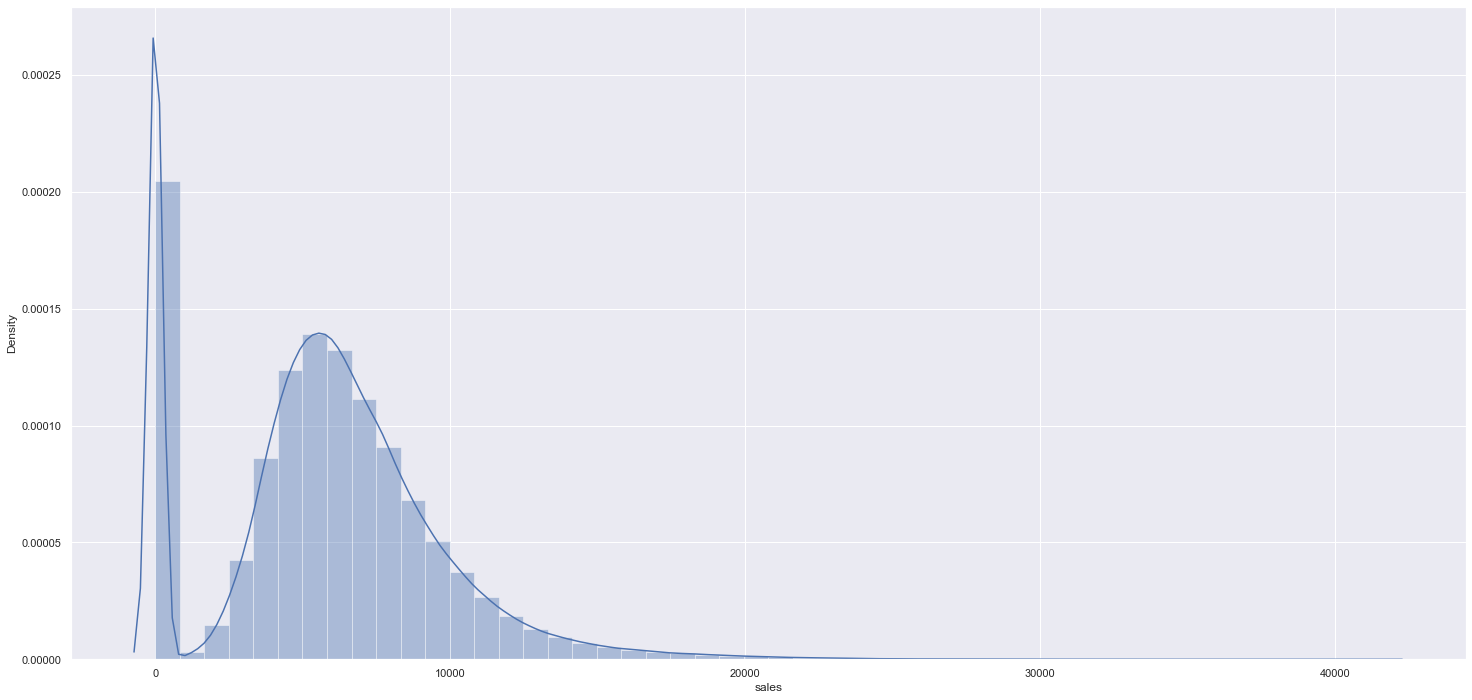

In [22]:
sns.distplot( df1['sales'])

## 1.7.1  Categorical Attributes

In [23]:
cat_attributes.apply (lambda x : x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

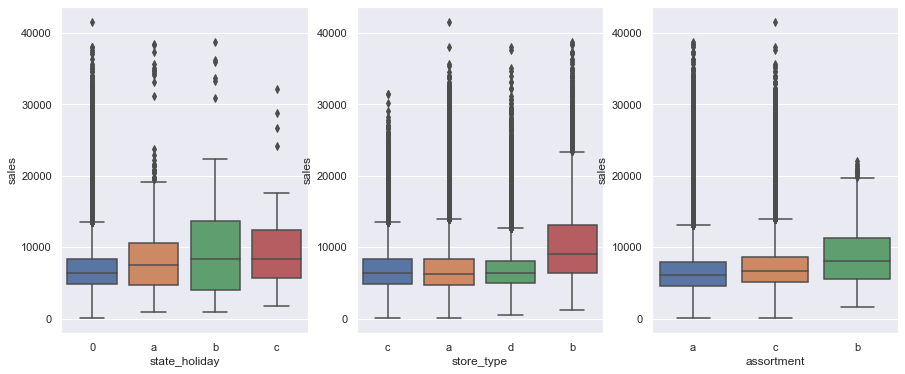

In [24]:
aux1=df1[(df1['state_holiday']!=0 ) & (df1['sales'] > 0)]

plt.figure(figsize=(15,6))
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales',data=aux1 )

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales',data=aux1 )

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales', data=aux1)



# 2.0. FEATURE ENGINEERING 

In [25]:
df2 = df1.copy()

## 2.1. HYPOTHESES MIND MAP

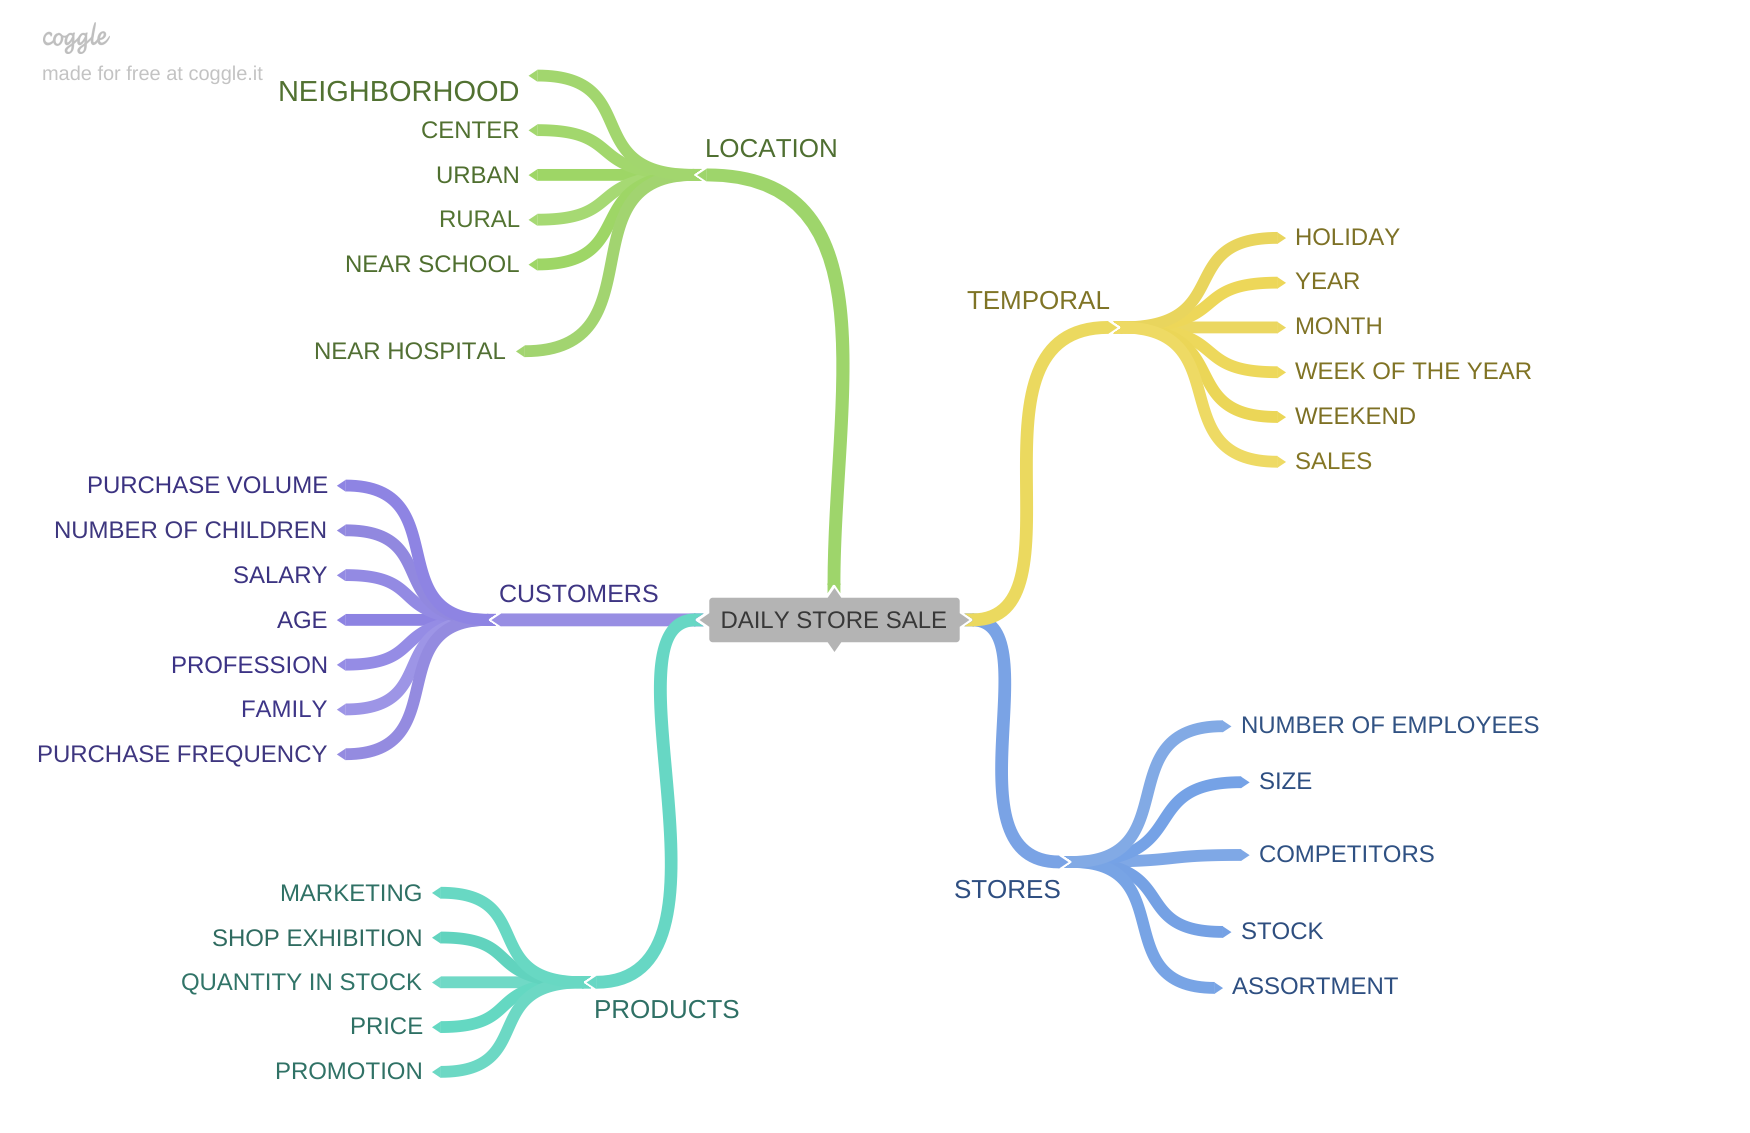

In [26]:
Image ('img/MIND_MAP_HYPOTESIS_DAILY_STORE_SALE.png')

## 2.2 CREATION OF HYPOTHESES

### 2.2.1 HYPOTESES SHOP 

**1.** Larger stores should sell more

**2.** Stores with a larger staff should sell more

**3.** Stores with fewer competitors should sell more.

**4.** Stores with a larger stock should sell more.

**5.** Stores with a larger assortment should sell more.

**6.** Stores with longer competitors should sell more. 

### 2.2.2 HYPOTESES PRODUCTS

**1.** Stores with a greater marketing should sell more.

**2.** Stores that exhibit more product sell more.

**3.** Stores with a fewer price shoul sells more.

**4.** Stores with a fewer price for longer should sell more. 

**5.** Stores whith extended promotion should sell more.

**6.** Stores with consecutive promotions should sell more.




### 2.2.3 HYPOTESES TEMPORAL

**1.** Stores with more holydays should sell less.

**2.** Stores that open in the first 6 months should sell more.

**3.** Stores that open on wekkend should sell more.

**4.** Stores should sell more after 10 day of the month.

**5.** Stores should sell less during scool holidays.

**7.** Stores should sell more over the years.

**8.** Stores that open on Christmas should sell more.

**9.** Stores should sell less during wekkend.

**10.** Stores should sell more in the second half in the year.

## 2.3. Final list of hypotheses

**1.** Stores with a larger assortment should sell more.

**2.** H2.Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores with fewer competitors should sell more.

**5.** Stores whith extended promotion should sell more.

**6.** Stores with consecutive promotions should sell more.

**7.** Stores that open on Christmas should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half in the year.

**10.** Stores should sell more after 10 day of the month.

**11.** Stores should sell less during wekkend.

**12.** Stores should sell less during scool holidays.














## 2.4. FEATURE ENGINEERING

In [27]:
# YEAR
df2['year']=df2['date'].dt.year

# MONTH
df2['month']=df2['date'].dt.month    
    
# DAY
df2['day']=df2['date'].dt.day

# WEEK OF YEAR
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# YEAR WEEK
df2['year_week']=df2['date'].dt.strftime('%Y-%W')

# COMPETITION SINCE
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'] , month = x['competition_open_since_month'] ,day = 1), axis = 1)         
df2['competition_time_month']=(( df2['date'] - df2['competition_since']) / 30 ).apply( lambda x: x.days).astype(int)

# PROMO SINCE

df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x:datetime.datetime.strptime(x + '-1','%Y-%W-%w')

                                              - datetime.timedelta( days= 7 ))
df2['promo_time_week'] = ( ( df2['date']-df2['promo_since'] ) / 7  ).apply (lambda x: x.days).astype ( int )

#df2['promo_time_week'] = ( ( df2['date']-df2['promo_since'] ) / 7  ).apply (lambda x: x.days).astype ( int )


#ASSORTMENT

df2['assortment'] = df2['assortment'].apply(lambda x:  'basic' if x == 'a' else 'extra' if x == 'b' else 'extended') 

#STATE HOLIDAY

df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' 
                                                  if x == 'b' else 'christmas' if x =='c' else 'regular_day')



# 3.0. FILTERING VARIABLES

In [28]:
df3= df2.copy()

## 3.1.  LINE FILTERING

In [29]:
df3 =df3[ ( df3['open']  != 0 ) & ( df3['sales']  > 0 )] 

## 3.2. COLOMN SELECTION

In [30]:
cols_drop = ['customers','open','promo_interval','month_map']
df3= df3.drop(cols_drop,axis=1)

# 4.0.EXPLORATORY DATA ANALYSIS

In [31]:
df4 = df3.copy()

## 4.1. UNIVARIATE ANALYSIS

### 4.1.1. Responde variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

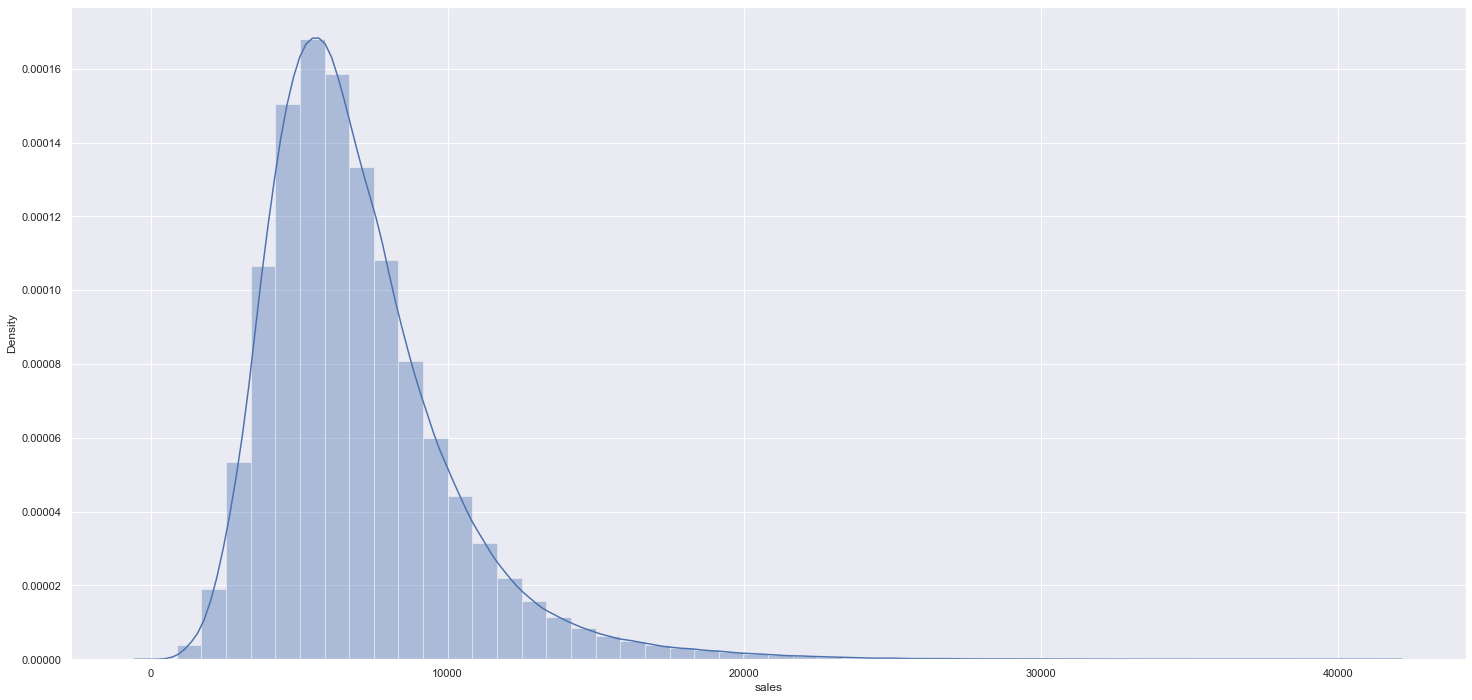

In [32]:
sns.distplot(df4['sales'])

### 4.1.2. Numerical Variable

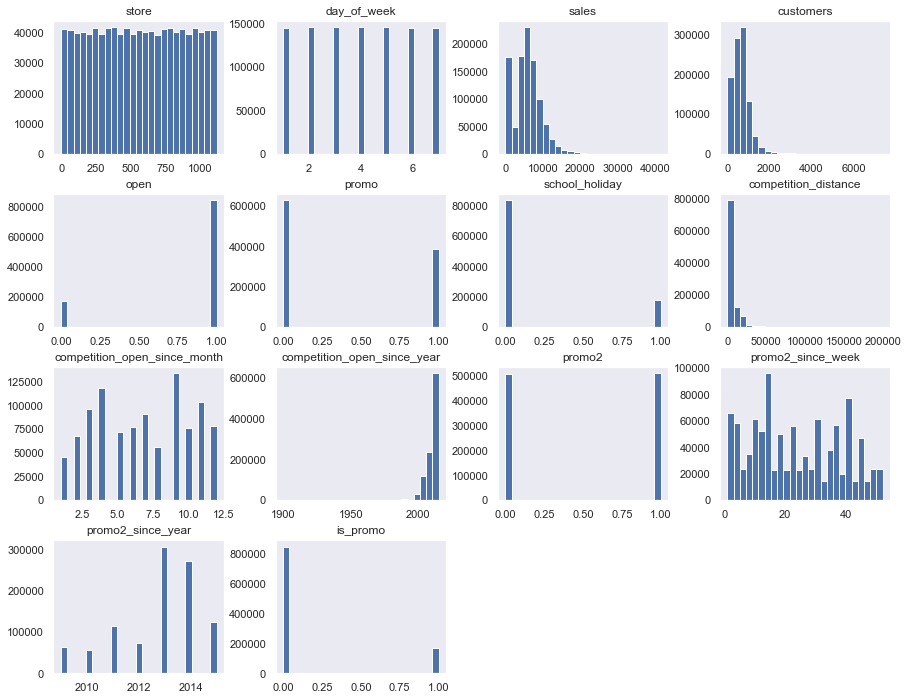

In [33]:
fig = plt.figure(figsize = (15,12))
num_attributes.hist(bins = 25, ax = fig.gca(), grid = False);

### 4.1.3. Caregorical Variable

In [34]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [35]:
df4['store_type'].drop_duplicates()
df4['state_holiday'].drop_duplicates()
df4['assortment'].drop_duplicates()


0         basic
3      extended
258       extra
Name: assortment, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

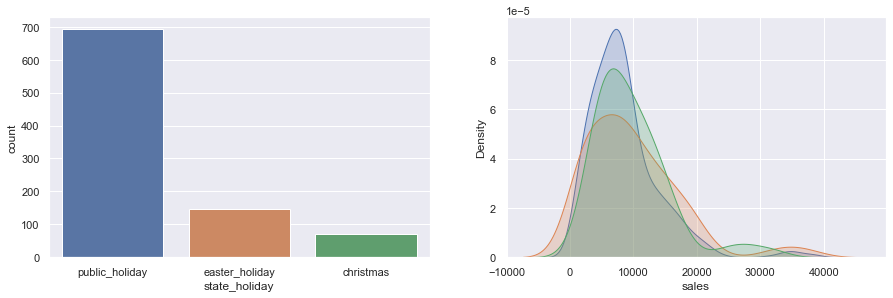

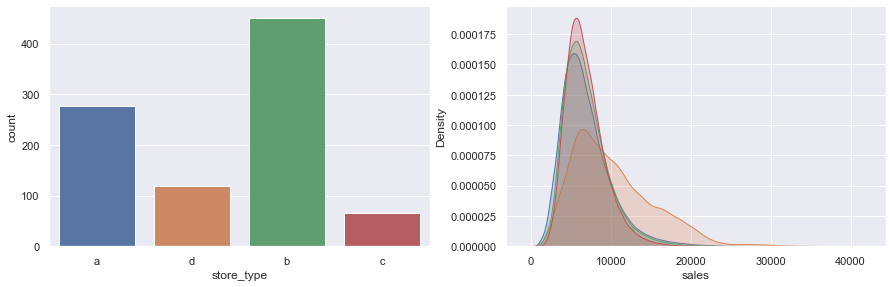

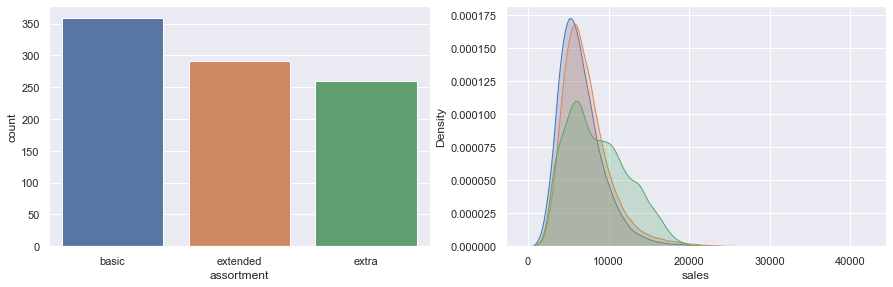

In [36]:
# state_holiday

plt.figure(figsize=(15,15))


plt.subplot( 3,2,1)
a= df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot( 3,2,2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday'] ['sales'],label = 'public holiday',shade= True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday'] ['sales'],label = 'public holiday',shade= True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas'] ['sales'],label = 'public holiday',shade= True )

#store_type
plt.figure(figsize=(15,15))

plt.subplot( 3,2,3)
sns.countplot(a['store_type'])

plt.subplot( 3,2,4)
sns.kdeplot( df4[df4['store_type'] == 'a'] ['sales'],label = 'a',shade= True )
sns.kdeplot( df4[df4['store_type'] == 'b'] ['sales'],label = 'b',shade= True )
sns.kdeplot( df4[df4['store_type'] == 'c'] ['sales'],label = 'c',shade= True )
sns.kdeplot( df4[df4['store_type'] == 'd'] ['sales'],label = 'd',shade= True )

#assortment
plt.figure(figsize=(15,15))

plt.subplot( 3,2,5)
sns.countplot(a['assortment'])

plt.subplot( 3,2,6)
sns.kdeplot( df4[df4['assortment'] == 'basic'] ['sales'],label = 'basic',shade= True )
sns.kdeplot( df4[df4['assortment'] == 'extended'] ['sales'],label = 'extended',shade= True )
sns.kdeplot( df4[df4['assortment'] == 'extra'] ['sales'],label = 'extra',shade= True )



## 4.2. BIVARIATE ANALYSIS

### H1. Stores with a larger assortment should sell more.

**False** The sum of stores with greater assortments is less.


Text(0.5, 1.0, 'Sales Mean')

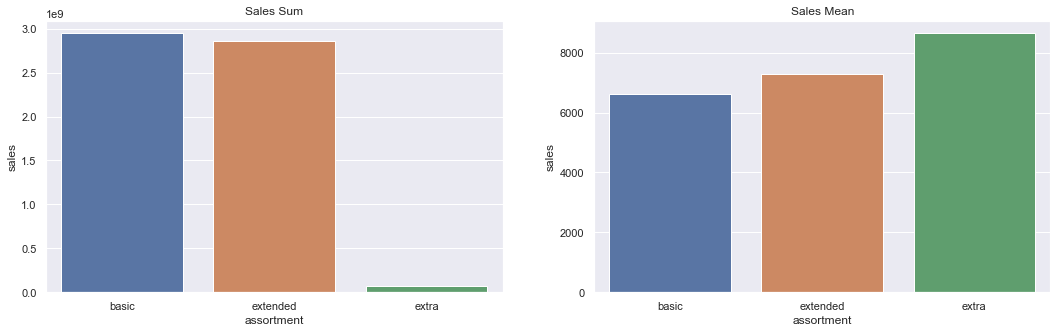

In [37]:
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
aux1 = df4[['assortment','sales']].groupby( 'assortment').sum().reset_index()
sns.barplot ( x = 'assortment', y = 'sales', data= aux1);
plt.title('Sales Sum')

#plt.figure(figsize=(10,5))

plt.subplot(1,2,2)

aux1 = df4[['assortment','sales']].groupby( 'assortment').mean().reset_index()
sns.barplot ( x = 'assortment', y = 'sales', data= aux1);
plt.title('Sales Mean')





<AxesSubplot:xlabel='year_week'>

<Figure size 1296x360 with 0 Axes>

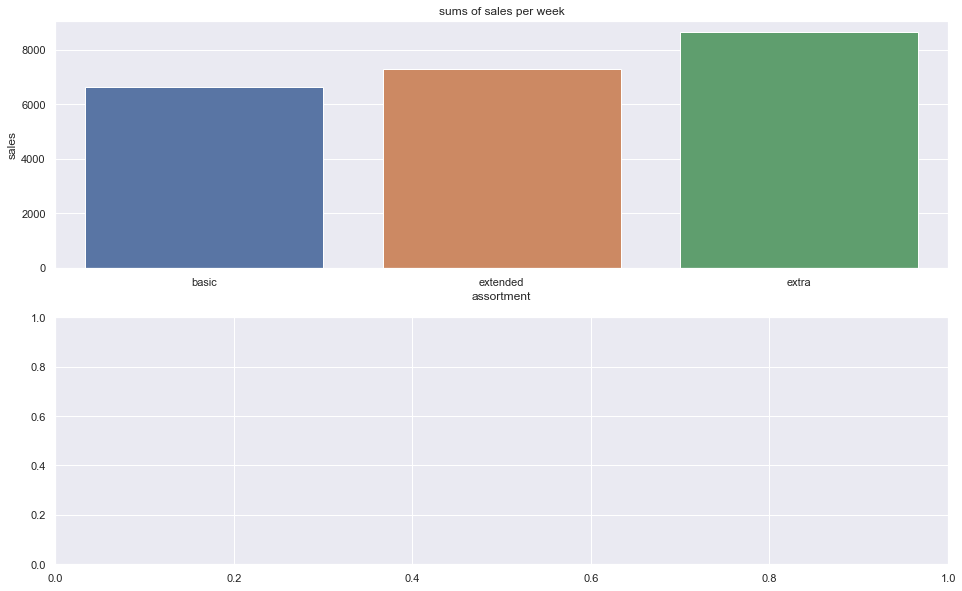

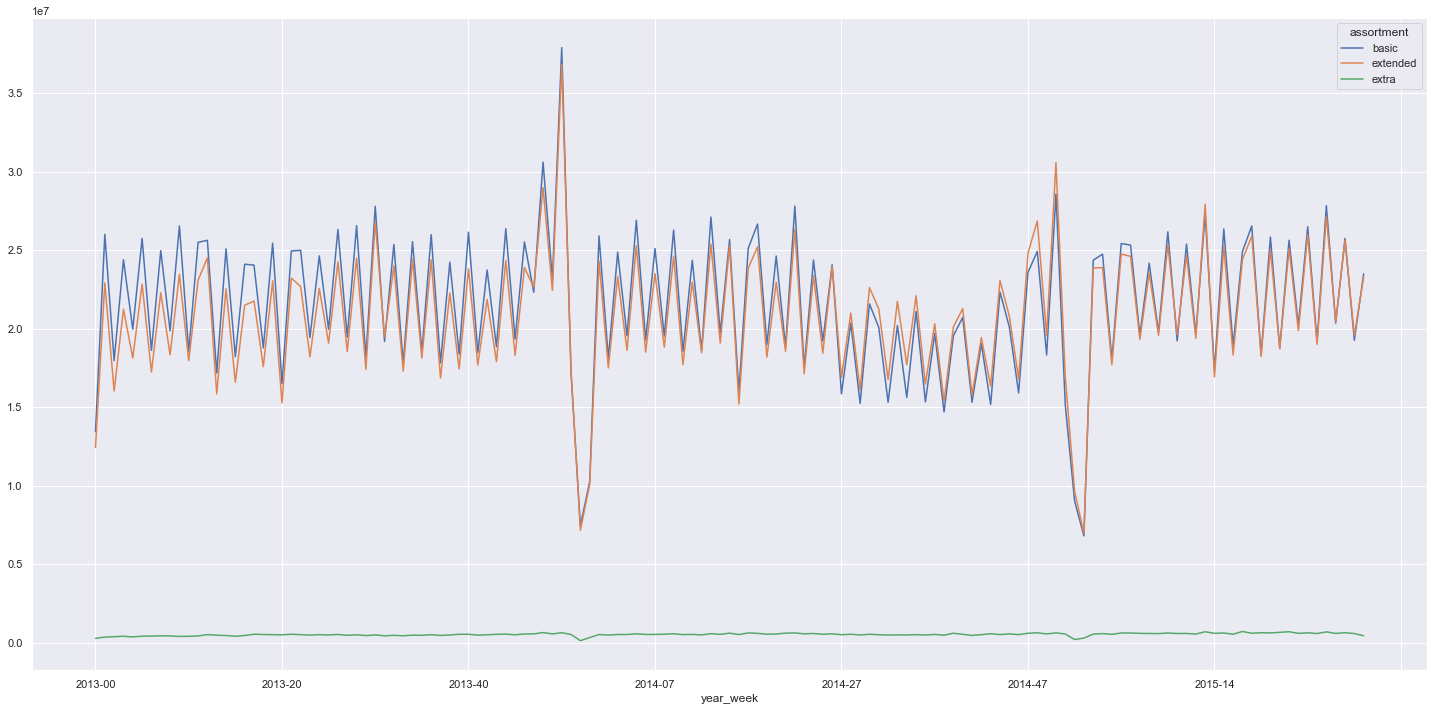

In [38]:
plt.figure(figsize=(18,5))
fig = plt.figure(figsize = (16,10))
grid = gridspec.GridSpec(2,2)


plt.subplot (grid[0,:])
aux2 = df4[['year_week','assortment','sales']].groupby(['year_week', 'assortment']).sum().reset_index()
sns.barplot ( x = 'assortment', y = 'sales', data= aux1);
plt.title('sums of sales per week')


plt.subplot (grid[1,:])
aux2.pivot ( index= 'year_week', columns = 'assortment',values = 'sales'  ).plot()

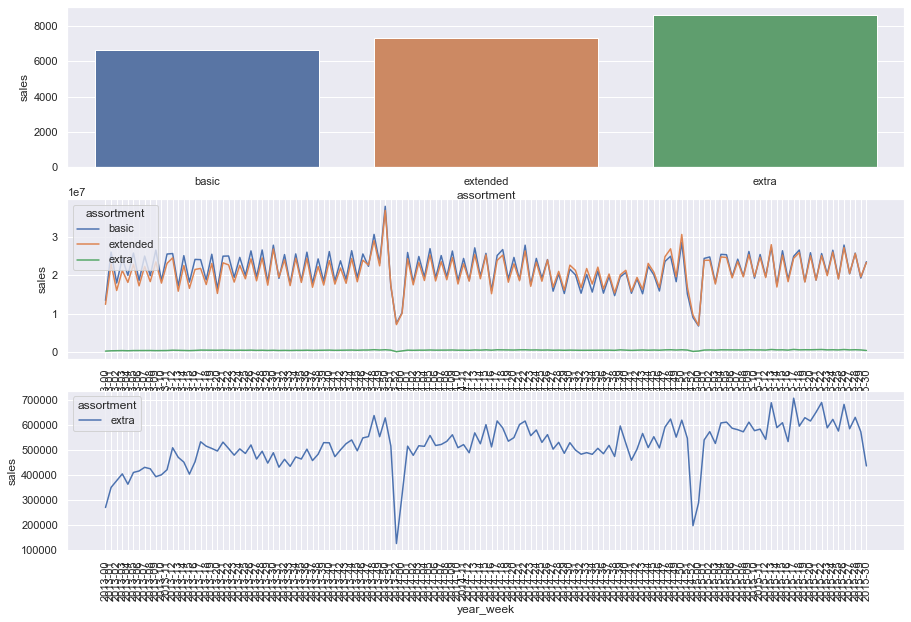

In [39]:
fig = plt.figure(figsize = (15,10))

plt.subplot (3,1,1)
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot (x = 'assortment', y = 'sales', data = aux1)

plt.subplot (3,1,2)
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
#aux2.pivot (index = 'year_week', columns = 'assortment', values = 'sales').plot()
sns.lineplot(x='year_week', y='sales', hue='assortment', data = aux2)
plt.xticks(rotation = 90);

plt.subplot (3,1,3)
aux3 = aux2 [ aux2['assortment'] == 'extra' ]
#aux2.pivot (index = 'year_week', columns = 'assortment', values = 'sales').plot()
sns.lineplot(x='year_week', y='sales', hue='assortment', data = aux3)
plt.xticks(rotation = 90);

### H2.Stores with closer competitors should sell less.

**False** Stores with competition closer  do not sell less, there not such relationship.

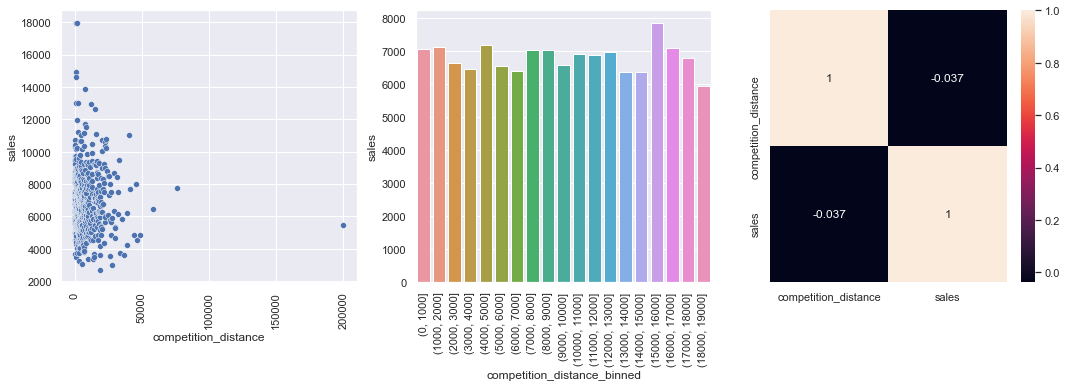

In [40]:
plt.figure(figsize=(18,5))

plt.subplot(1,3 ,1)
aux1 = df4[['competition_distance','sales']].groupby( 'competition_distance').mean().reset_index()
sns.scatterplot( x = 'competition_distance', y= 'sales', data = aux1)
plt.xticks ( rotation =90);

plt.subplot(1,3 ,2)
bins = list (np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins = bins )
aux2 = aux1[['competition_distance_binned','sales']].groupby( 'competition_distance_binned').mean().reset_index()
sns.barplot ( x = 'competition_distance_binned',y ='sales' , data= aux2  );
plt.xticks ( rotation =90);

plt.subplot(1,3,3)
sns.heatmap( aux1.corr( method= 'pearson'), annot= True );


### H3. Stores with longer competitors should sell more.

**False** Stores with longer competitor do not sell more.

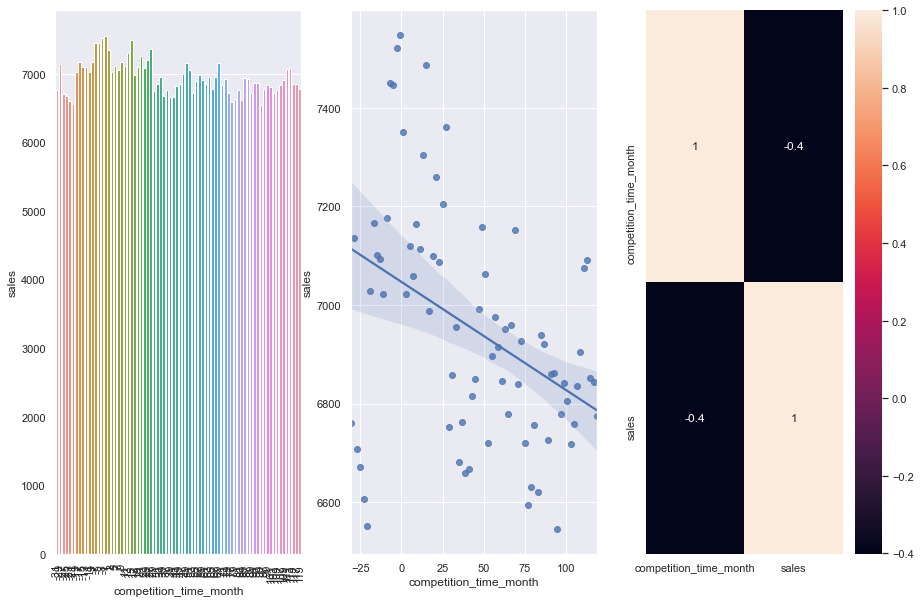

In [41]:
fig = plt.figure( figsize = (15,10))


plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby( 'competition_time_month').mean().reset_index()
aux2 =  aux1[ (aux1['competition_time_month'] < 120) & ( aux1['competition_time_month']) != 0] 

sns.barplot( x='competition_time_month', y = 'sales', data = aux2 )
plt.xticks(rotation = 90 );

plt.subplot(1,3,2)
sns.regplot( x='competition_time_month', y = 'sales', data = aux2 )

plt.subplot(1,3,3)
sns.heatmap( aux2.corr ( method = 'pearson'), annot = True);


### H4 Stores whith extended promotion should sell more.

**False** Because stores with active promotions for longer do not sell anymore.



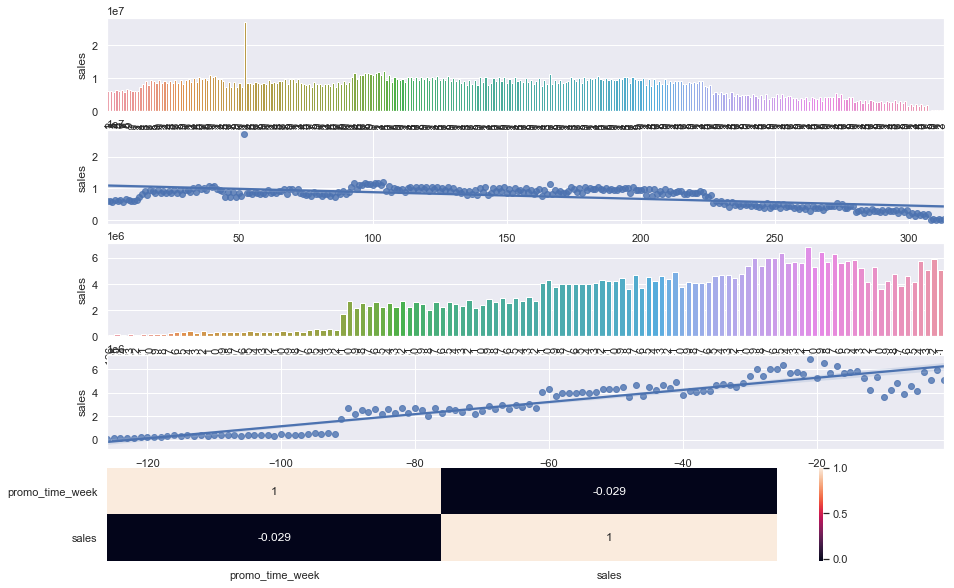

In [42]:
fig = plt.figure( figsize = (15,10))

aux1 = df4[[ 'promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

#sns.barplot(x ='promo_time_week' ,y = 'sales', data = aux1 );


plt.subplot( 5,1,1)
aux2 = aux1[aux1['promo_time_week'] > 0] #promo extended
sns.barplot(x ='promo_time_week' ,y = 'sales', data = aux2 )
plt.xticks( rotation = 90);

plt.subplot( 5,1,2)
sns.regplot(x ='promo_time_week' ,y = 'sales', data = aux2 )


plt.subplot(5,1,3 )
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular
sns.barplot(x ='promo_time_week' ,y = 'sales', data = aux3 )
plt.xticks(rotation = 90);



plt.subplot( 5,1,4)
sns.regplot(x ='promo_time_week' ,y = 'sales', data = aux3 )

plt.subplot( 5,1,5)
sns.heatmap( aux1.corr ( method= 'pearson'), annot=True);

### H5 Stores with consecutive promotions should sell more.

**False** Stores with consecutive promotions do not sell anymore.

In [43]:
df4[['promo','promo2','sales']].groupby ([ 'promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


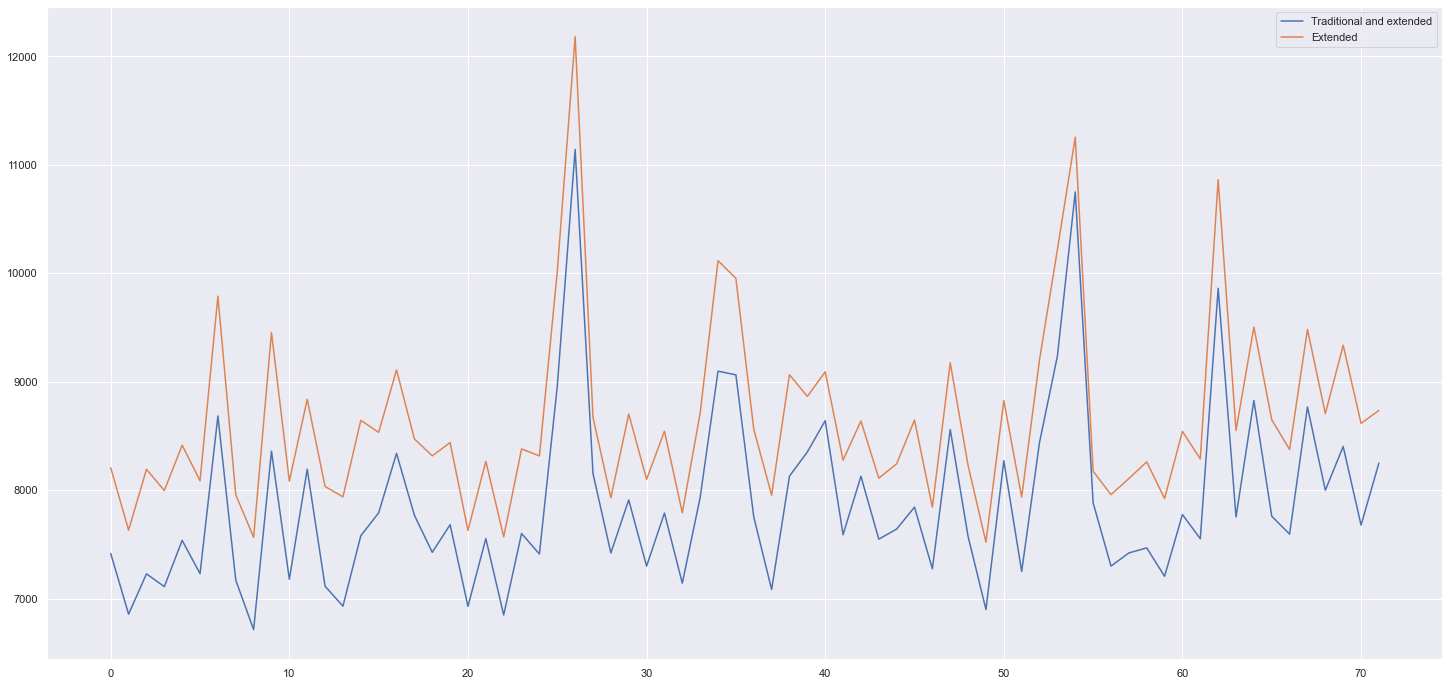

In [44]:
aux1 = df4 [( df4['promo'] == 1) & (df4['promo2'] == 1 )] [['year_week','sales']].groupby('year_week').mean().reset_index()

ax = aux1.plot()


aux2 = df4 [( df4['promo'] == 1) & (df4['promo2'] == 0 )] [['year_week','sales']].groupby('year_week').mean().reset_index()
aux2.plot(ax = ax)

ax.legend(labels = ['Traditional and extended','Extended']);

### **7** Stores that open on Christmas should sell more.

**False** Stores opened at Christmas sell less.


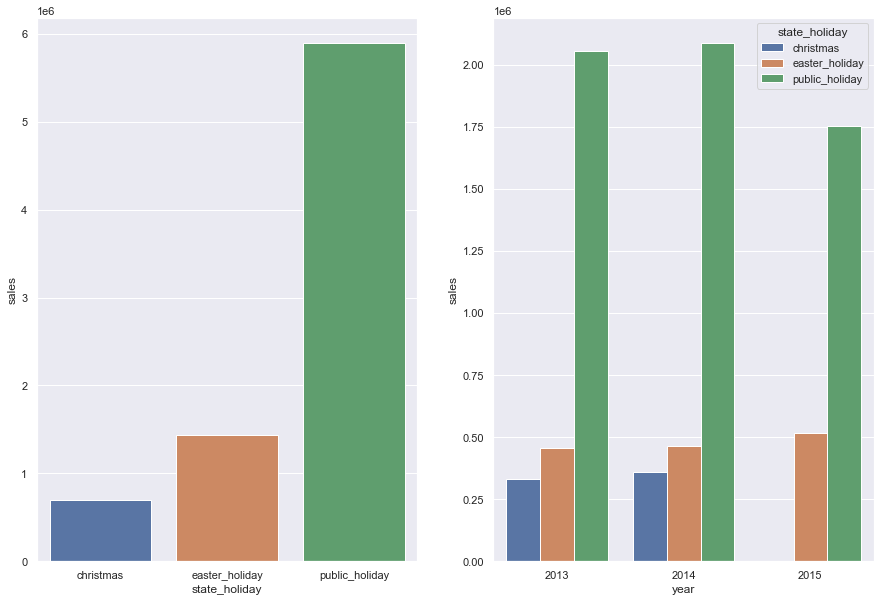

In [45]:
fig = plt.figure( figsize = (15,10))

aux = df4[df4['state_holiday'] != 'regular_day']


plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x= 'state_holiday',y = 'sales',data = aux1);


plt.subplot(1, 2, 2)
aux2 = aux [['year', 'state_holiday', 'sales']].groupby( [ 'year', 'state_holiday']).sum().reset_index()
sns.barplot(x= 'year' , y = 'sales', hue = 'state_holiday', data = aux2);

### **8**  Stores should sell more over the years.

**False** Stores no longer sell over the years



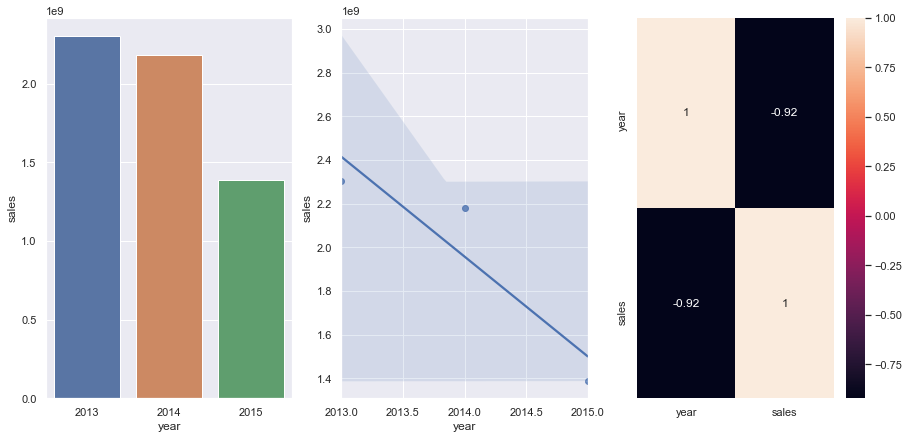

In [46]:
fig = plt.figure( figsize = (15,7))

aux1 =  df4[['year', 'sales']].groupby ( 'year').sum().reset_index()


plt.subplot( 1, 3, 1)
sns.barplot(x= 'year', y = 'sales', data= aux1 );


plt.subplot( 1, 3, 2)
sns.regplot(x= 'year', y = 'sales', data= aux1 );


plt.subplot( 1, 3, 3)
sns.heatmap(aux1.corr( method = 'pearson'), annot= True );

### **9** Stores should sell more in the second half in the year.

**False** Stores no longer sell in the second half.



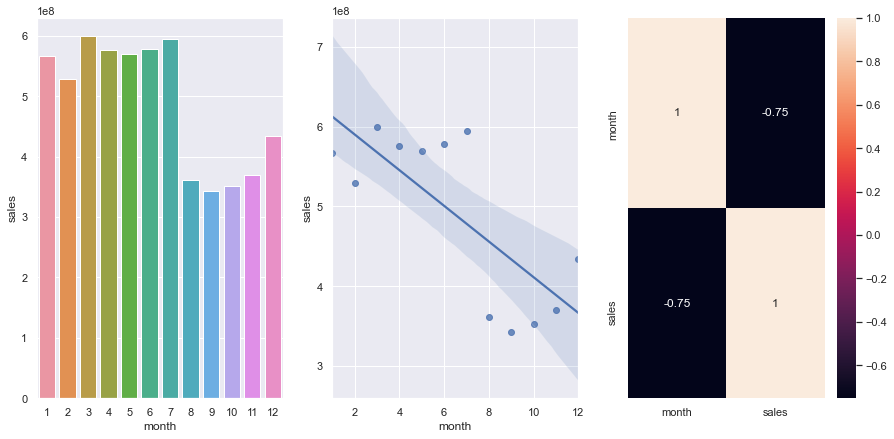

In [47]:
fig = plt.figure( figsize = (15,7))

aux1 =  df4[['month', 'sales']].groupby ('month').sum().reset_index()


plt.subplot( 1, 3, 1)
sns.barplot(x= 'month', y = 'sales', data= aux1 );


plt.subplot( 1, 3, 2)
sns.regplot(x= 'month', y = 'sales', data= aux1 );


plt.subplot( 1, 3, 3)
sns.heatmap(aux1.corr( method = 'pearson'), annot= True );

### **10** Stores should sell more after 10 day of the month.

**True** Stores must sell more after 10 days of the month.

<AxesSubplot:xlabel='before_after', ylabel='sales'>

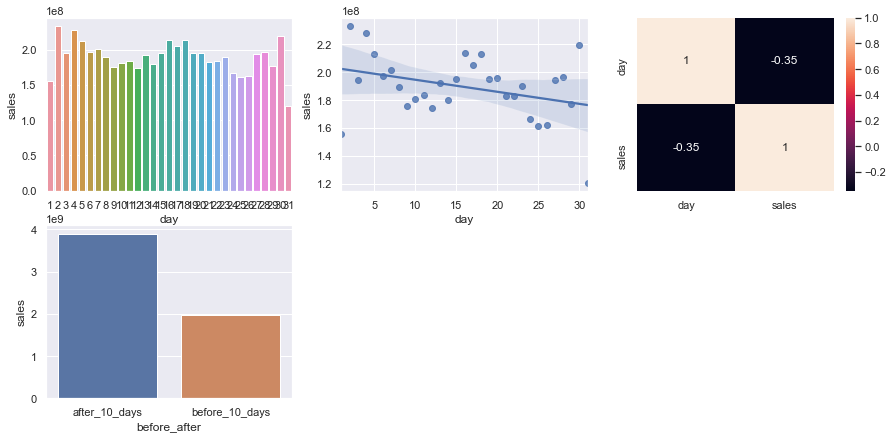

In [48]:
fig = plt.figure( figsize = (15,7))

aux1 =  df4[['day', 'sales']].groupby ('day').sum().reset_index()


plt.subplot( 2,3, 1)
sns.barplot(x= 'day', y = 'sales', data= aux1 );


plt.subplot( 2,3, 2)
sns.regplot(x= 'day', y = 'sales', data= aux1 );


plt.subplot( 2,3, 3)
sns.heatmap(aux1.corr( method = 'pearson'), annot= True );

aux1 ['before_after'] = aux1 ['day'].apply (lambda x:'before_10_days' if x <= 10 else 'after_10_days')


plt.subplot( 2,3, 4)
aux2 =  aux1 [['before_after','sales']].groupby( 'before_after').sum().reset_index()
sns.barplot( x = 'before_after', y = 'sales', data= aux2)

### **11** Stores should sell less during wekkend.

**True** Stores sell less on the weekend.


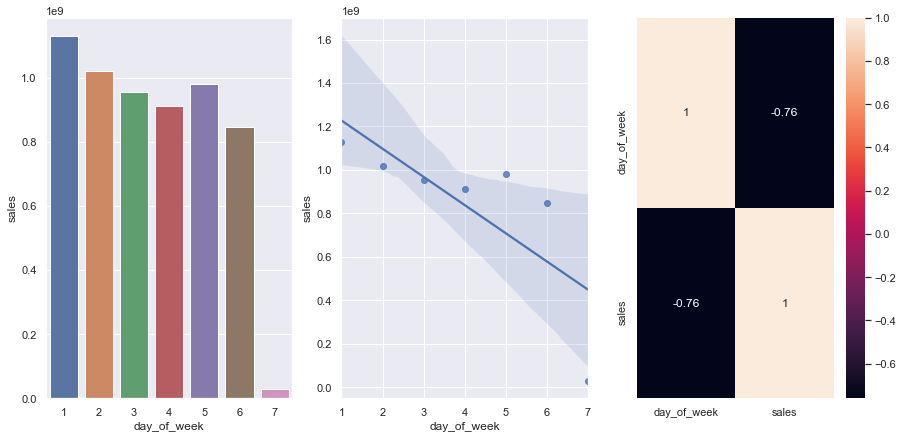

In [49]:
fig = plt.figure( figsize = (15,7))

aux1 =  df4[['day_of_week', 'sales']].groupby ( 'day_of_week').sum().reset_index()


plt.subplot( 1, 3, 1)
sns.barplot(x= 'day_of_week', y = 'sales', data= aux1 );


plt.subplot( 1, 3, 2)
sns.regplot(x= 'day_of_week', y = 'sales', data= aux1 );


plt.subplot( 1, 3, 3)
sns.heatmap(aux1.corr( method = 'pearson'), annot= True );

### **12** Stores should sell less during scool holidays.

**True** Stores sell less during school holidays, except during July and August.

<AxesSubplot:xlabel='month', ylabel='sales'>

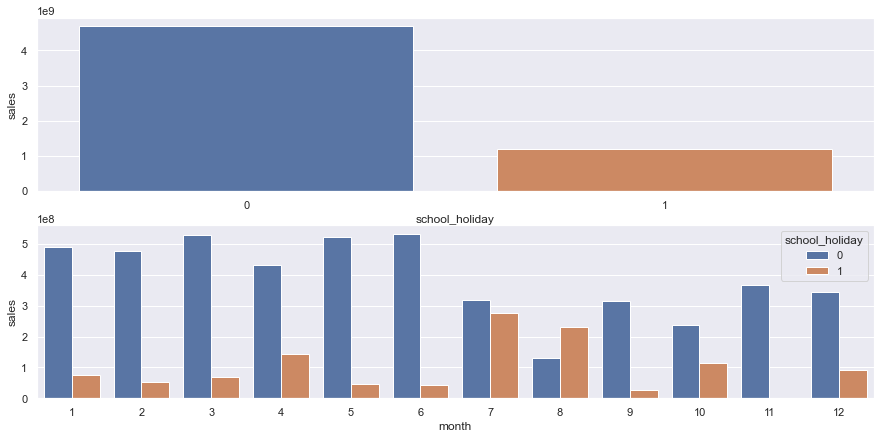

In [50]:
fig = plt.figure( figsize = (15,7))


plt.subplot( 2, 1 , 1 )
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot( x = 'school_holiday' , y = 'sales', data= aux1)


plt.subplot( 2, 1 , 2 )
aux2 = df4[['month','school_holiday','sales']].groupby(['month' ,'school_holiday']).sum().reset_index()
sns.barplot( x = 'month' , y = 'sales',hue= 'school_holiday', data= aux2)

### 4.2.1. Summary Of Hypotheses

In [51]:
from tabulate import tabulate

In [52]:
tab = [ ['Hypotheses','Conclusion','Relevance'],
        ['H1', 'False', 'Low' ],
        ['H2', 'False', 'Mean'],
        ['H3', 'False', 'Mean'],
        ['H4', 'false', 'Low' ],
        ['H5', '-', '-' ],
        ['H6','False', 'Low' ],
        ['H7', 'False', 'Mean' ],
        ['H8', 'False', 'High' ],
        ['H9', 'False', 'High' ],
        ['H10', 'True', 'High' ],
        ['H11', 'True', 'High' ],
        ['H12', 'True', 'Low' ],
       ]
        
print ( tabulate( tab ,headers = 'firtstrow'))        

f           i           r
----------  ----------  ---------
Hypotheses  Conclusion  Relevance
H1          False       Low
H2          False       Mean
H3          False       Mean
H4          false       Low
H5          -           -
H6          False       Low
H7          False       Mean
H8          False       High
H9          False       High
H10         True        High
H11         True        High
H12         True        Low


## 4.3. MULTIVARIATE ANALYSIS

### 4.3.Numerical Attributes

<AxesSubplot:>

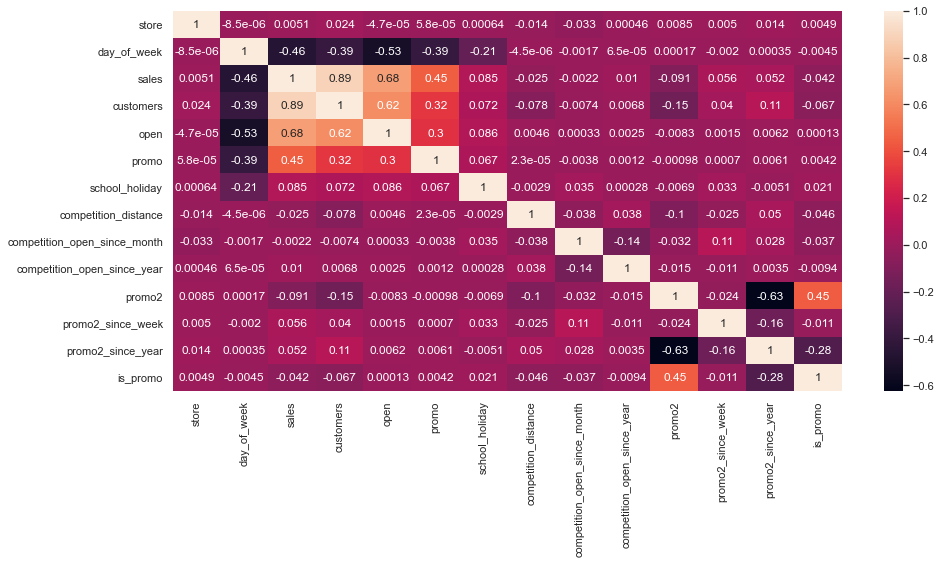

In [53]:
fig = plt.figure( figsize = (15,7))

correlation = num_attributes.corr( method = 'pearson' )
sns.heatmap(correlation, annot = True)

### 4.3.2 Caregorical Attributes

<AxesSubplot:>

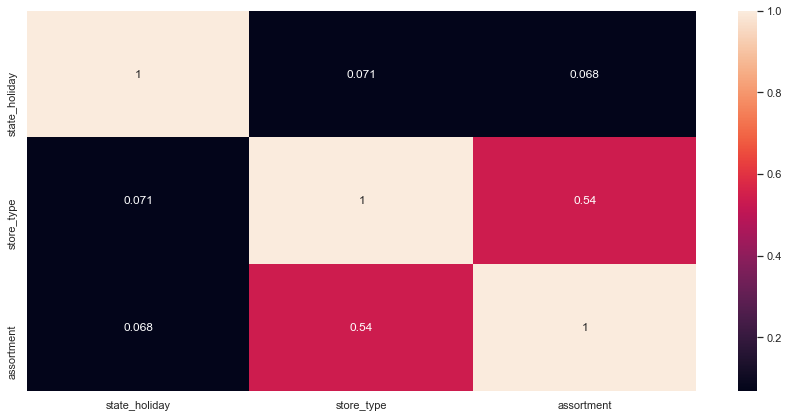

In [54]:
# Only categorical data
a = df4.select_dtypes ( include = 'object')

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )


a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )


a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

#Final dataset 
d = pd.DataFrame ({'state_holiday' : [a1,a2,a3],
                   'store_type'    : [a4,a5,a6],
                   'assortment'    : [a7,a8,a9]
                  })

d = d.set_index(d.columns)


fig = plt.figure( figsize = (15,7))

sns.heatmap (d, annot = True )

# 5.0. DATA PREPARATION

In [55]:
df5 = df4.copy()

## 5.1. Normalization

**None of the numerical variable have a normal distribution, thus the normalization it's not fit.** 

## 5.2 Rescaling

In [56]:
rs = RobustScaler ()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump (rs , open ('parameter/competition_distance_scaler.pkl','wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump (rs , open ('parameter/competition_time_month_scaler.pkl','wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump (rs , open ('parameter/promo_time_week_scaler.pkl','wb'))


# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump ( mms , open ('parameter/year_scaler.pkl','wb'))


## 5.3. Transformation

### 5.3.1. Encoding

In [57]:
# State holiday - One Hot Encoding
df5 = pd.get_dummies ( df5, prefix = ['state_holiday'], columns = [ 'state_holiday'])

# Store type - Label Encoding
le = LabelEncoder ()
df5 ['store_type'] = le.fit_transform ( df5 ['store_type'])
pickle.dump( le, open ('parameter/store_type_scaler.pkl', 'wb'))


# Assortment - Ordinal Encoding
assortment_dict= {'basic': 1,
                  'extra': 2,
                  'extended': 3 ,
                 }

df5['assortment'] = df5 ['assortment'].map (assortment_dict)

### 5.3.2 Response Variable Transformation

In [58]:
df5 ['sales'] = np.log1p(df5['sales'])

<AxesSubplot:xlabel='sales', ylabel='Density'>

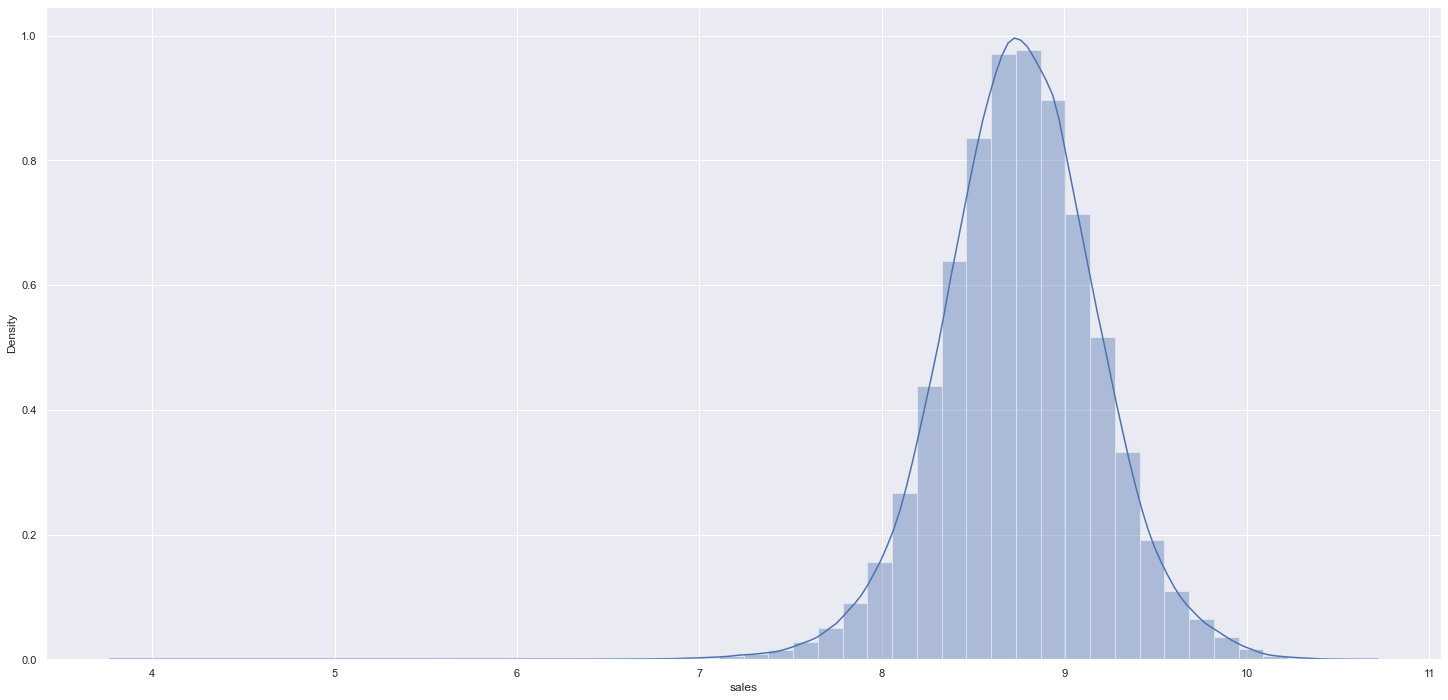

In [59]:
sns.distplot (df5['sales'])

### 5.3.2. Nature Transformation

In [60]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply ( lambda x :np.sin ( x * ( 2 * np.pi /7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply ( lambda x :np.cos ( x * ( 2 * np.pi /7 ) ) )

# month
df5['month_sin'] = df5['month'].apply ( lambda x :np.sin ( x * ( 2 * np.pi /12 ) ) )
df5['month_cos'] = df5['month'].apply ( lambda x :np.cos ( x * ( 2 * np.pi /12 ) ) )

# day
df5['day_sin'] = df5['day'].apply ( lambda x :np.sin ( x * ( 2 * np.pi /30 ) ) )
df5['day_cos'] = df5['day'].apply ( lambda x :np.cos ( x * ( 2 * np.pi /30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply ( lambda x :np.sin ( x * ( 2 * np.pi /52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply ( lambda x :np.cos ( x * ( 2 * np.pi /52 ) ) )


# 6.0. FEATURE SELECTION

In [61]:
df6  = df5.copy()

## 6.1. Split Dataframe into Training and Test Dataset

In [62]:
cols_drop = [ 'week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop ( cols_drop, axis = 1)

In [63]:
df6 [ [ 'store', 'date']].groupby('store').max().reset_index()['date'][0] -datetime.timedelta( days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [64]:
# Training dataset

X_train = df6 [df6 [ 'date'] < '2015-06-19']
y_train = X_train['sales']


# Test dataset

X_test = df6 [df6 [ 'date'] >=   '2015-06-19']
y_test = X_test['sales']


## 6.2. Boruta as Feature Selector

In [65]:
# Training and test for Boruta
#X_train_n = X_train.drop( [ 'date','sales'], axis = 1).values
#y_train_n = y_trains.values.ravel ()

# Define RandomForestRegressor
#rf = RandomForestRegressor ( n_jobs = -1)



# Define Boruta
#borutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42 ).fit ( X_train_n, y_train_n)

### 6.2.1 Best Features from Boruta

In [66]:
#cols_selected = boruta.support_.tolist()


# Best Features
#X_train_fs = X_train.drop ( ['date','sales'], axis = 1)
#cols_selected_boruta =  X_train_fs.iloc [ : , cols_selected].columns.to_list()


# Not selected Boruta
#cols_not_selected_boruta =  list( np. setdiff1d (X_train_fs.columns , cols_selected_boruta))

## 6.3 Manual Feature Selection

In [67]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_sin',
                        'day_cos',
                        'month_cos',
                        'month_sin',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']

# Columns to add
feat_to_add = ['date', 'sales']



# Final Features

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0. MACHINE LEARNING MODEL

In [68]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

In [69]:
x_training = X_train[ cols_selected_boruta_full]

## 7.1. Average Model

In [70]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#Prediction
aux2 =  aux1[[ 'store', 'sales']].groupby ( 'store' ).mean().reset_index().rename( columns = {'sales' : 'predictions'})
aux1 = pd.merge (aux1, aux2, how = 'left', on='store')
yhat_baseline = aux1[ 'predictions' ]

#Performace
baseline_result = ml_error( 'Avarege Model', np.expm1( y_test),np.expm1(yhat_baseline))

baseline_result

,Model Name,MAE,MAPE,RMSE
0,Avarege Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [71]:
# Model
lr = LinearRegression().fit(x_train, y_train)

# Prediction
yhat_lr = lr.predict( x_test )


# Performace
lr_result = ml_error('Linear Regression', np.expm1( y_test), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [72]:
lr_result_cv = cross_validation (x_training , 5, 'Linear Regression', lr, verbose=False ) 
lr_result_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model -Lasso

In [73]:
# Model
lrr =  Lasso ( alpha = 0.01).fit(x_train, y_train)

# Prediction
yhat_lrr = lrr.predict( x_test )


# Performace
lrr_result = ml_error('Linear Regression-Lasso', np.expm1( y_test), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression-Lasso,1891.704881,0.289106,2744.451739


### 7.3.1. Linear Regression Regularized Model -Lasso- Cross Validation

In [74]:
lrr_result_cv = cross_validation (x_training , 5, 'Lasso', lrr, verbose=False ) 
lrr_result_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random  Forest Regressor

In [75]:
# Model
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state  = 42).fit(x_train, y_train)

# Prediction
yhat_rf = rf.predict( x_test )


# Performace
rf_result = ml_error('Random Forest Regressor', np.expm1( y_test), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.741859,0.099843,1008.83426


### 7.4.1. Random  Forest Regressor - Cross Validation

In [76]:
rf_result_cv = cross_validation (x_training , 5, 'Random Forest Regressor', rf, verbose= True ) 
rf_result_cv


KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5


,Model name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,838.56 +/- 219.67,0.12 +/- 0.02,1257.66 +/- 320.75


## 7.5. XGBoost Regressor

In [77]:
# model
model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
                              n_estimators = 3000,
                              eta = 0.03,
                              max_depth = 5,
                              subsample = 0.3,
                              colsample_bytree = 0.9,
                              min_child_weight = 8).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,752.733801,0.113217,1080.375477


### 7.5.1. XGBoost Regressor - Cross Validation

In [78]:
#xgb_result_cv = cross_validation (x_training , 5, 'XGBoost Regressor', model_xgb, verbose= True ) 
#xgb_result_cv

## 7.6. Compare Model's Performance

### 7.6.1.  Single Performace

In [79]:
modelling_result = pd.concat( [ baseline_result, lr_result,lrr_result, rf_result, xgb_result ])
modelling_result.sort_values( 'RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.741859,0.099843,1008.834260
0,XGBoost Regressor,752.733801,0.113217,1080.375477
0,Avarege Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression-Lasso,1891.704881,0.289106,2744.451739


 ### 7.6.2 Real Performace - Cross Validation

In [80]:
#modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
#modelling_result_cv.sort_values('RMSE CV')

# 8.0. HyperParameter Fine Tuning

## 8.1. Random Search

In [81]:
#param = { 'n_estimators' : [1500, 1700, 2500, 3000, 3500],
#          'eta' : [0.01,0.03],
#          'max_depth' : [3,5,9],
#          'subsample' : [0.1,0.5,0.7],
#          'colsample_bytree' : [0.3,0.7,0.9],    
#          'min_child_weight' : [3, 8, 15]  } 
#         
#
#MAX_EVAL = 5


In [82]:
#final_result = pd.DataFrame()


#for i in range ( MAX_EVAL):
#    # Choose values for parameters radomly
#    hp = {k:random.sample( v, 1 )[0] for k, v  in param.items()}
#    
#    print ( hp )
    
    
#    # model
#    model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
#                                  n_estimators = hp['n_estimators'],
#                                  eta = hp['eta'],
#                                  max_depth = hp ['max_depth'],
#                                  subsample = hp['subsample'],
#                                  colsample_bytree = hp['colsample_bytree'],
#                                  min_child_weight = hp ['min_child_weight'])


  

#    # performance
#    result = cross_validation(x_training, 5 , 'XGBoost Regressor', model_xgb, verbose = False)
#    final_result = pd.concat ( [final_result, result ] )
                                                  
#final_result                                     
 
    
    
                    

## 8.2. Final Model 

In [106]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }
         

In [107]:
# Model
model_xgb_tuned = xgb.XGBRegressor( objective = 'reg:squarederror',
                           n_estimators = param_tuned['n_estimators'],
                                             eta = param_tuned['eta'],
                                max_depth = param_tuned ['max_depth'],
                                 subsample = param_tuned['subsample'],
                   colsample_bytree = param_tuned['colsample_bytree'],
                  min_child_weight = param_tuned ['min_child_weight']).fit( x_train, y_train)

# Prediction 

yhat_xgb_tuned = model_xgb_tuned.predict( x_test)
  
# Performance
xgb_result_tuned = ml_error('XGBoost Regressor',np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned 

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,771.56446,0.116113,1107.547706


In [108]:
mpe = mean_percentage_error(np.expm1( y_test), np.expm1(yhat_xgb_tuned))
mpe    

-0.01751171083795079

# 9.0.TRANSLATION AND INTERPREPATATION OF THE ERROR

In [109]:
df9 = X_test [cols_selected_boruta_full]

# Rescale


df9 ['sales'] = np.expm1 ( df9 ['sales'])
df9 ['predictions'] = np.expm1 (yhat_xgb_tuned)

## 9.1. Businesse Performance

In [110]:
# Sum of Predictions
df91 = df9 [['store', 'predictions']].groupby ('store').sum().reset_index ()


# MAE and MAP
df9_aux1 = df9[[ 'store', 'sales', 'predictions']]. groupby ('store').apply (lambda x : mean_absolute_error( x['sales'],   x['predictions'] ) ).reset_index().rename (columns = {0 : 'MAE'})
df9_aux2 = df9[[ 'store', 'sales', 'predictions']]. groupby ('store').apply (lambda x : mean_absolute_percentage_error( x['sales'],   x['predictions'] ) ).reset_index().rename (columns = {0 : 'MAPE'})


# Merge
df9_aux3 = pd.merge ( df9_aux1, df9_aux2, how = 'inner' , on= 'store' )
df92= pd.merge (df91, df9_aux3 , how = 'inner', on = 'store')


# Scenarios
df92['Worst_scenario'] = df92 ['predictions'] - df92 ['MAE']
df92 ['Best_scenario'] = df92 ['predictions'] + df92 ['MAE']

#Order Columns

df92 = df92 [['store', 'predictions', 'Worst_scenario', 'Best_scenario','MAE', 'MAPE']]



In [111]:
df92.sort_values ('MAPE', ascending = False).head()

,store,predictions,Worst_scenario,Best_scenario,MAE,MAPE
291,292,108072.695312,104731.809532,111413.581093,3340.885781,0.589377
908,909,222065.046875,214160.795898,229969.297852,7904.250977,0.520001
169,170,204035.750000,202628.081187,205443.418813,1407.668813,0.349191
901,902,197917.187500,196565.587957,199268.787043,1351.599543,0.336712
875,876,199276.015625,195277.707127,203274.324123,3998.308498,0.322179


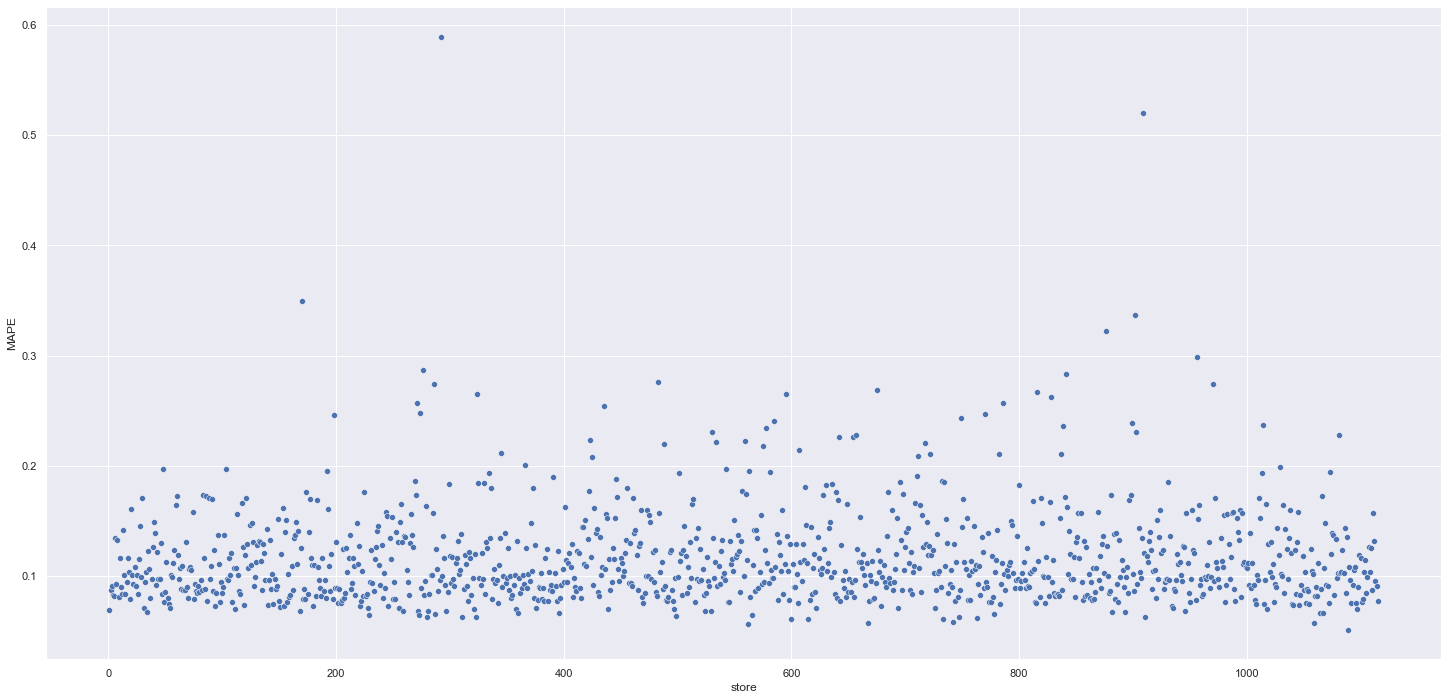

In [112]:
sns.scatterplot( x = 'store', y = 'MAPE', data = df92);

## 9.2. Total Performance

In [113]:
df93 = df92[['predictions', 'Worst_scenario', 'Best_scenario']].apply (lambda x: np.sum (x ),axis = 0 ).reset_index().rename ( columns = {'index': 'Scenario' , 0 : 'Values'})
df93 ['Values'] = df93 ['Values'].map ('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$286,202,368.00"
1,Worst_scenario,"R$285,338,968.02"
2,Best_scenario,"R$287,065,833.68"


## 9.3. Machine Learning Performance

In [114]:
df9 ['error'] = df9['sales'] - df9 ['predictions']
df9 ['error_rate'] = df9 ['predictions'] / df9 [ 'sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

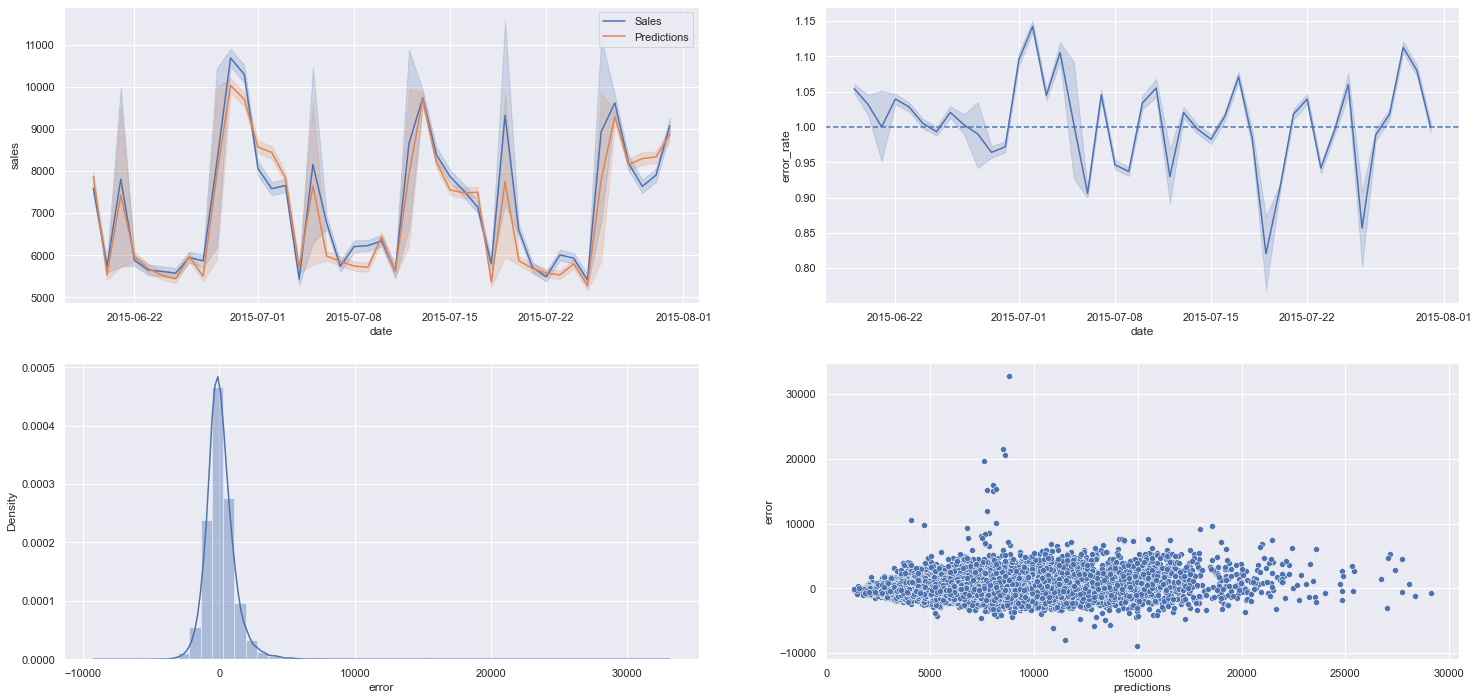

In [115]:
plt.subplot (2,2,1)
sns.lineplot ( x= 'date', y = 'sales',  data = df9, label = 'Sales'  )
sns.lineplot ( x= 'date', y = 'predictions',  data = df9, label = 'Predictions'  )


plt.subplot (2,2,2)
sns.lineplot ( x= 'date', y = 'error_rate',  data = df9)
plt.axhline(1, linestyle='--')

plt.subplot (2,2,3)
sns.distplot ( df9 ['error'])

plt.subplot (2,2,4)
sns.scatterplot ( df9['predictions'],df9['error'])

# 10.0.DEPLOY MODEL TO PRODUCTION

In [116]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open( 'C:/Users/Leand/OneDrive/Favoritos compartilhados/DATA SCIENCE/LEANDRO/Projeto_Rossman/Predict-Time-Series/model/Store_Sales_Prediction.pkl', 'wb'))

## 10.1. Rossmann Class

In [117]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime



class Rossmann ( object ) :
    
    def __init__( self ) :
        self.home_path = 'C:/Users/Leand/OneDrive/Favoritos compartilhados/DATA SCIENCE/LEANDRO/Projeto_Rossman/Predict-Time-Series/'
        self.competition_distance_scaler   = pickle.load ( open (self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load ( open (self.home_path + 'parameter/competition_time_month_scaler.pkl','rb'))
        self.promo_time_week_scaler        = pickle.load ( open (self.home_path + 'parameter/promo_time_week_scaler.pkl','rb'))
        self.year_scaler                   = pickle.load ( open (self.home_path + 'parameter/year_scaler.pkl','rb'))
        self.store_type_scaler            = pickle.load( open (self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))  
    
    def data_cleaning ( self, df1 ):

        ## 1.1. Rename Columns
        
        cols_old = ['Store', 'DayOfWeek', 'Date','Open', 'Promo',
        'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
        'CompetitionDistance', 'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
        'Promo2SinceYear', 'PromoInterval']

        snakecase= lambda x : inflection .underscore(x)

        cols_new= list(map( snakecase, cols_old ))

        #  Rename
        df1.columns= cols_new
        
        
        ## 1.3. Data Type   

        df1['date']= pd.to_datetime(  df1['date'])




        ## 1.5. Fillout NA    


        #competition_distance 

        df1['competition_distance']= df1['competition_distance'].apply(lambda x:  200000.0 if math.isnan (x) else x)

        #competition_open_since_month  

        df1['competition_open_since_month']=df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)


        #competition_open_since_year     

        df1['competition_open_since_year']=df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)


        #promo2_since_week 


        df1['promo2_since_week']=df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)


        #promo2_since_year


        df1['promo2_since_year']=df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)


        #promo_interval

        month_map={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

        df1['promo_interval'].fillna(0,inplace=True)

        df1['month_map']=df1['date'].dt.month.map(month_map) 

        df1['is_promo']=df1[['promo_interval','month_map']].apply( lambda x:0 if x['promo_interval']== 0 
                                                                  else 1 if x ['month_map'] in x ['promo_interval'].split(',') else 0 , axis= 1 )

        ## 1.6. Change Types

        df1['competition_open_since_month']= df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year']= df1['competition_open_since_year'].astype(int)

        df1['promo2_since_week']= df1['promo2_since_week'].astype(int)
        df1['promo2_since_year']= df1['promo2_since_year'].astype(int)
        
        return df1

    def feature_engineering( self, df2) :    
        
        # YEAR
        df2['year']=df2['date'].dt.year

        # MONTH
        df2['month']=df2['date'].dt.month    

        # DAY
        df2['day']=df2['date'].dt.day

        # WEEK OF YEAR
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # YEAR WEEK
        df2['year_week']=df2['date'].dt.strftime('%Y-%W')

        # COMPETITION SINCE
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'] , month = x['competition_open_since_month'] ,day = 1), axis = 1)         
        df2['competition_time_month']=(( df2['date'] - df2['competition_since']) / 30 ).apply( lambda x: x.days).astype(int)

        # PROMO SINCE

        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

        df2['promo_since'] = df2['promo_since'].apply(lambda x:datetime.datetime.strptime(x + '-1','%Y-%W-%w')- datetime.timedelta( days= 7 ))

                                                      
        df2['promo_time_week'] = ( ( df2['date']-df2['promo_since'] ) / 7  ).apply (lambda x: x.days).astype ( int )

        


        #ASSORTMENT

        df2['assortment'] = df2['assortment'].apply(lambda x:  'basic' if x == 'a' else 'extra' if x == 'b' else 'extended') 

        #STATE HOLIDAY

        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x =='c' else 'regular_day') 
                                                            
        
        
        
        # 3.0. FILTERING VARIABLES        
        
        ## 3.1.  LINE FILTERING
        
        df2 =df2[ ( df2['open']  != 0 ) ] 
        
        ## 3.2. COLOMN SELECTION
        
        cols_drop = ['open','promo_interval','month_map']
        df2= df2.drop(cols_drop,axis=1)
        
        return df2
    
    
    def data_preparation (self,df5 ):
         
    
    
        ## 5.2 Rescaling


        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
        

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )
       

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )


        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )


        ### 5.3.1. Encoding

        # State holiday - One Hot Encoding
        df5 = pd.get_dummies ( df5, prefix = ['state_holiday'], columns = [ 'state_holiday'])

        # Store type - Label Encoding
        df5 ['store_type'] = self.store_type_scaler.fit_transform ( df5 ['store_type'])



        # Assortment - Ordinal Encoding
        assortment_dict= {'basic': 1,'extra': 2,'extended': 3  }
                          
                          
                        

        df5['assortment'] = df5 ['assortment'].map (assortment_dict)



        ### 5.3.2. Nature Transformation

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply ( lambda x :np.sin ( x * ( 2 * np.pi /7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply ( lambda x :np.cos ( x * ( 2 * np.pi /7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply ( lambda x :np.sin ( x * ( 2 * np.pi /12 ) ) )
        df5['month_cos'] = df5['month'].apply ( lambda x :np.cos ( x * ( 2 * np.pi /12 ) ) )

        # day
        df5['day_sin'] = df5['day'].apply ( lambda x :np.sin ( x * ( 2 * np.pi /30 ) ) )
        df5['day_cos'] = df5['day'].apply ( lambda x :np.cos ( x * ( 2 * np.pi /30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply ( lambda x :np.sin ( x * ( 2 * np.pi /52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply ( lambda x :np.cos ( x * ( 2 * np.pi /52 ) ) )
        
        cols_selected = ['store', 'promo', 'store_type',
                         'assortment','competition_distance', 'competition_open_since_month',
                         'competition_open_since_year','promo2', 'promo2_since_week',
                         'promo2_since_year','competition_time_month', 'promo_time_week',
                         'day_of_week_sin','day_of_week_cos', 'month_sin','month_cos',
                         'day_sin','day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        
        return df5[cols_selected]

    
    def get_prediction (self, model, original_data,test_data):
        # Predicition
        pred = model.predict (test_data)
        
        # Join Pred Into The Original Data
        original_data [ 'predicition'] = np.expm1(pred)
        
        return original_data.to_json ( orient ='records', date_format = 'iso' )

## 10.2. API Handler



In [118]:
import pickle
import pandas as pd
from flask import Flask, request, Response



#from  rossmann.Rossmann import Rossmann


# Loading model

model = pickle.load(open ('C:/Users/Leand/OneDrive/Favoritos compartilhados/DATA SCIENCE/LEANDRO/Projeto_Rossman/Predict-Time-Series/model/Store_Sales_Prediction.pkl', 'rb'))


# Initialize API
app = Flask ( __name__ )

@app.route( '/rossman/predict', methods = ['POST'] )

def rossman_predict():
    test_json= request.get_json()
        
    if test_jason: # there is data
        
        if isinstance (test_json,dict): # Unique Example
            test_raw =  pd.DataFrame (test_json, index = [0])
        
        else : # Multiple Examples
        
            test_raw =  pd.DataFrame (test_json, columns = test_json[0].keys())
            
            
                
            
        # Instantiate Rossmann Class
        pipeline = Rossmann()
            
            
        # Data Cleaning
        df1 = pipeline.data_cleaning( test_raw)
    
        # Feature Enginering
        df2 = pipeline.feature_engineering (df1)
        
        # Data Preaparation
        df3  = pipeline.data_preparation( df2)
        
        # Prediction
        df_response = pipeline.get_prediction ( model, test_raw, df3)
        
        
        return  df_response
         
      
    else:
        return Response('{}', status = 200, mimetype = 'application/json')
        
        
        
        
        
        
if __name__ == '__main__':
    app.run( '127.0.0.1', debug=True )

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with stat


SystemExit: 1

## 10.2. API Tester


In [119]:
# Loading test dataset
df10 = pd.read_csv('C:/Users/Leand/OneDrive/Favoritos compartilhados/DATA SCIENCE/LEANDRO/Projeto_Rossman/Predict-Time-Series/Data/test.csv')

In [120]:
import requests

# Merge Test Dataset + Store

df_test = pd.merge( df10, df_store_raw, how = 'left', on = 'Store')

# Chosse Store for Prediction
df_test = df_test[df_test['Store'].isin( [22,12,24]) ]

    
# Remove Closed Days
df_test = df_test[ df_test [ 'Open'] != 0]
df_test = df_test[~df_test [ 'Open'].isnull()]
df_test = df_test.drop ('Id', axis = 1)
    

In [121]:
# Convert Datafrane to json

data = json.dumps(df_test.to_dict( orient = 'records'))


In [126]:
# API Call
#url = 'http://127.0.0.1:5000/rossmann/predict'
url = 'https://rossmannpredictionmodel.herokuapp.com/rossmann/predict'

header = {'Content-type' : 'application/json'}
data = data

r = requests.post( url, data = data, headers = header)
print( 'Status Code {}'.format( r.status_code ))


ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [123]:
d1 = pd.DataFrame (r.json(),columns = r.json( )[0].keys ())

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
d1.head()

In [ ]:
d2 = d1 [['store','prediction']].groupby ('store').sum().reset_index()

for i in range (len (d2)):
    print( 'Store number {} will sell R${:,.2f} in the next 6 week'.format( d2.loc[i,'store'],d2.loc[i,'prediction']) )